# Synthetic test for particle filter with an optimal proposal
Summary of the particle filter code to compare standard particle filter and particle filter with the optimal proposal in an example with synthetic leveling data (i.e., only the vertical component of the displacement).

In [1]:
# Library
import os
from numpy import *
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot
from numpy import linalg as LA

from numpy.random import randn
from numpy.linalg import inv

from function_compute_def130623 import nucleus_u_cartesian

plt.close('all')

### Forward modeling: compute subsidence 

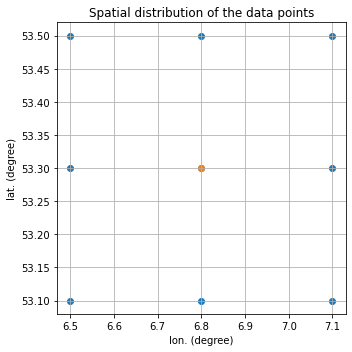

In [2]:
### Initialization
# Parameters
nu = 0.32

# Initialize Deep subsurface
deep_setup = np.loadtxt('input_files/reservoir_setup_groningen.txt')
depth_d  = deep_setup[1] 
thick_d = deep_setup[2]  # m
Cm_d = deep_setup[3]  # 1/MPa
dx, dy = deep_setup[0]*111*1e3, deep_setup[0]*111*1e3 # m

vol_nucl = dx * dy * thick_d

# Load the position of the nuclei
nuclei_pos = loadtxt('input_files/nuclei_position_groningen.txt')
n_nuclei = len(nuclei_pos)

####################
# Setting the area #
####################
grid_degree = 1
DA_setup = loadtxt('input_files/DA_setup.txt')

# Location of the nucleus
x_center = 6.83
y_center = 53.35
x0_area = DA_setup[2]
y0_area = DA_setup[4]
xmax_area = DA_setup[3]
ymax_area = DA_setup[5]

## Data : on a random grid for now
Ny=9
obs = np.zeros((Ny,3))
input_data = np.zeros((Ny, 3))
# data set: grid
x_pnt = np.linspace(x0_area, xmax_area, int(np.sqrt(Ny))) 
y_pnt = np.linspace(y0_area, ymax_area, int(np.sqrt(Ny)))
x_grid, y_grid = np.meshgrid(x_pnt, y_pnt)
input_data[:,0] = x_grid.reshape(-1)
input_data[:,1] = y_grid.reshape(-1)
# observation used for the assimilation
obs[:,0] = input_data[:,0]
obs[:,1] = input_data[:,1]


# Location of the nucleus of strain for the reservoir model
Nx = 1 # because we have 1 parameter per location

## Plot the location of the observations --> to improve later
plt.figure(figsize=(5,5))
plt.scatter(obs[:,0], obs[:,1])
plt.scatter(obs[4,0], obs[4,1])
#plt.plot(x_field_km, y_field_km, 'k')
plt.xlabel('lon. (degree)')
plt.ylabel('lat. (degree)')
plt.title('Spatial distribution of the data points')
#plt.colorbar(label='Displacement (mm)') 
#plt.xlim(220, 275)
#plt.ylim(560, 615)
#plt.axis('equal')
plt.tight_layout()
plt.grid(True)

In [3]:
## Setup for the data assimilation
# measurement error
sigma_e = 5e-3 # SD for the measurement error in m

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Subsidence synthetic data (m)')]

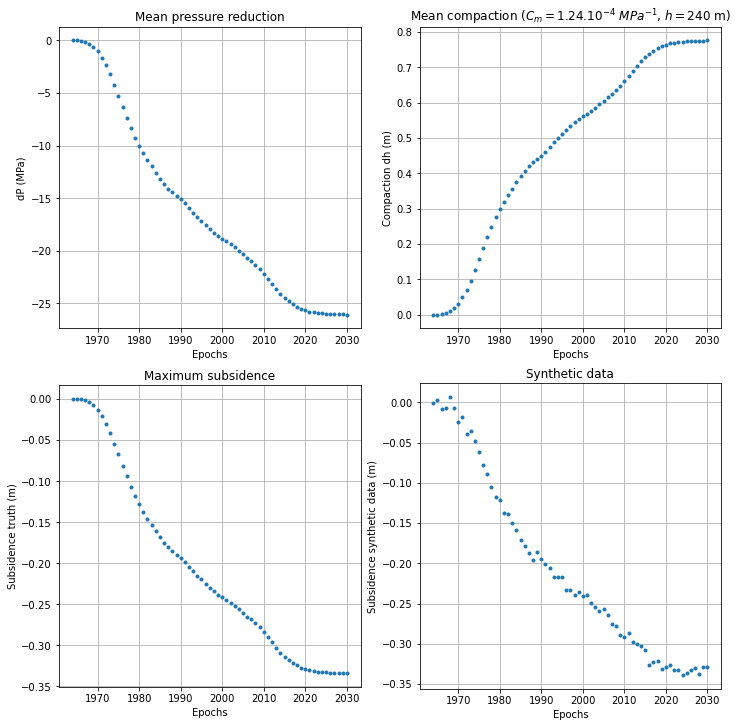

In [4]:
### Create truths of the model

# Pressure drop in the reservoir (from the NAM)
pressuredata = loadtxt('input_files/meanpressure_in_time.txt')
# relative to 1964
pressure = pressuredata[:,1] - pressuredata[7,1]
mean_dp = pressure[7:74] * 0.1 # conversion MPa
# Create array of dates
dates = pressuredata[7:74, 0]

# Compute the equivalent compaction at each epoch
dh = Cm_d * mean_dp * thick_d
dl2 = dx*dy

### Forward model
# Create data frame with true displacement per epoch
df_disp = pd.DataFrame(obs[:,0:2], columns=['pnt_lon','pnt_lat'])
df_synthdata = pd.DataFrame(obs[:,0:2], columns=['pnt_lon','pnt_lat'])

nepoch = len(dates)
disp_u = np.zeros(len(dates))
data_u = np.zeros(len(dates))

# Compute subsidence (Reservoir only)
for n in range(len(dates)): # epochs
    u_deep_cart = np.zeros(Ny)
    name = str(int(dates[n]))
    
    for i in range(len(nuclei_pos)):
        u_deep_cart = u_deep_cart + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[i,:], dh[n]*n_nuclei, nu, dl2, grid_degree) 

    # Component of the deformation in cartesian coordinates: we suppose that it in the the est, north and up direction
    ux = u_deep_cart[0]
    uy = u_deep_cart[1]
    uz = u_deep_cart[2]
    
    # Just for the plot
    disp_u[n] = -np.max(uz)
    data_u[n] = -(np.max(uz) + np.random.normal(0, sigma_e))
    # Data frame for assimilation
    df_disp[name] = uz
    df_synthdata[name] = uz + np.random.normal(np.zeros(Ny), sigma_e)
    
    
## Dynamical model: exponential decay
disp0 = 0 # displacement at time 0
# rate over the entire period
rate = (disp_u[nepoch-1] - (disp_u[0])) / (dates[nepoch-1] - dates[0])
rate = - 0.015 # m/year

disp_t = rate * (dates - dates[0])

### Plot the result on subfigure: total estimate, deep, shallow
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize=(10,10), sharey=False, constrained_layout=True )
       
ax0.plot(dates,mean_dp, '.')
ax0.set_title('Mean pressure reduction')

ax1.plot(dates, -dh, '.')
ax1.set_title('Mean compaction ($C_m=1.24.10^{-4}$ $MPa^{-1}$, $h=240$ m)')

# True (maximal) vertical displacement
ax2.plot(dates,disp_u,'.')
ax2.set_title('Maximum subsidence')

# difference observation - estimate
ax3.plot(dates, data_u, '.')
ax3.set_title('Synthetic data')

ax0.set_box_aspect(1)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
#axs[3].set_box_aspect(1)

#for ax in axs.flat:
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax0.set(xlabel='Epochs', ylabel='dP (MPa)')
ax1.set(xlabel='Epochs', ylabel='Compaction dh (m)')
ax2.set(xlabel='Epochs', ylabel='Subsidence truth (m)')
ax3.set(xlabel='Epochs', ylabel='Subsidence synthetic data (m)')




## Particle filter with standard proposal 
Only with 9 observations for now, later with the true data point from empirical dataset

In [5]:
Ne = 100
nrun = 1 # to plot histograms

# uz prior of deformation (state)
ux_p_def = np.zeros((Ny, Ne))     
uy_p_def = np.zeros((Ny, Ne))     
uz_p_def = np.zeros((Ny, Ne)) 
forecast_k = np.zeros((Ny, Ne)) 
forecast_sub = np.zeros((Ne, nepoch))  

w_maxSPF = np.zeros(nrun)

result = np.zeros((nrun, 3))
result_ae = np.zeros((nrun, Nx))
x_p = np.zeros(Ne)

mu_prior_deep = -0.2
sigma_prior_deep = 0.1

sigma_lik = 1e-3

#epoch = 1968 - 1964 
epoch = 1972 -1964

for simu in range(nrun):
    # Weight array
    p_w = np.ones(Ne, dtype=np.float64)
    # Likelihoods array
    dlpsi = np.zeros((Ne, Ny), dtype=np.float64)

    x_p = np.random.normal(mu_prior_deep, sigma_prior_deep,Ne) # in Pa -1

    ## Create the prior of deformation: compute the deformation at the observation points given the value of each particle
    for i in range(Ne): # take the ith set of prior compaction
        u_field =0
        for j in range(n_nuclei): # take the contribution of all nuclei at the Ny observation points
            u_field = u_field + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[j,:], x_p[i]*n_nuclei, nu, dl2, grid_degree)
        
        # displacement at time tk-1 given the prior at time tk-2
        ux_p_def[:,i] = u_field[0]
        uy_p_def[:,i] = u_field[1]
        uz_p_def[:,i] = u_field[2]
    
        # Compute rate for the dynamical model and get displacement at time k
        # rate = (disp_u[nepoch-1] - (disp_u[0])) / (dates[nepoch-1] - dates[0])
        rate = (uz_p_def [:,i] - disp0) / (dates[epoch] - dates[0])
        # Ensemble members at time k: 
        #rate of dimension Ny
        # forecast_k of dimension (Ny x Ne)
        forecast_k[:,i] = disp0 + rate * (dates[epoch] - dates[0])
        
        # for the observation point #4 for the plot
        forecast_sub[i,:] = disp0 + rate[4] * (dates - dates[0])
               
    
    ## Calculation of the difference data/model
    # transpose the array
    u_p_def = forecast_k.T

    # Difference data and model prediction at time k
    for i in range(Ne):
        for j in range(Ny):
            
            dlpsi[i,j] = (df_synthdata.iloc[j,2+epoch] - u_p_def[i,j])**2 # meter**2
            
    # Calculation of the likelihoods: gaussian distribution
    for i in range(Ne):
        dlpsi[i, :] = (1/sqrt(2*pi*sigma_lik**2))*np.exp(-0.5*dlpsi[i, :]/(sigma_lik**2))

    # Calculation of the weights
    for i in range(Ne):
        for j in range(Ny):
            p_w[i] = p_w[i] * dlpsi[i,j]

    # Normalization
    p_w = p_w / np.sum(p_w)
    
     ###############################
    # Analysis for the simulation #
    ###############################
    ## Weighted mean for the estimation of the compaction coefficient
    estimate = np.zeros(Nx)
    for i in range(Nx):
        estimate[i] = np.sum(np.multiply(x_p, p_w.T))

    deep_estimate = estimate[Nx-1]
    
    w_maxSPF[simu] = np.max(p_w)
    
print(w_maxSPF)

[0.59036986]


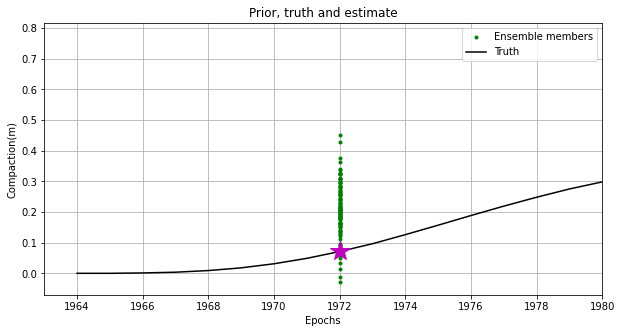

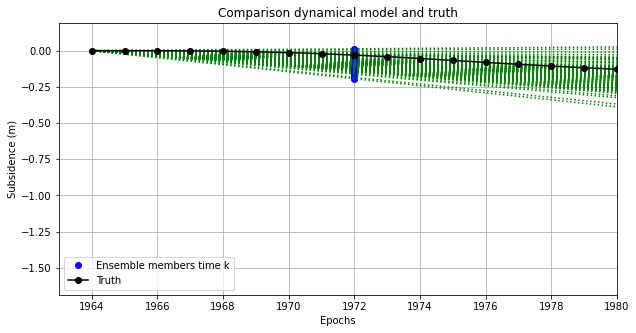

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
# -x_p to visualize a positive compaction
ax.plot((1964+epoch)*np.ones(Ne), -x_p, 'g.', label='Ensemble members')
ax.plot(dates, -dh, 'k-', label='Truth')
ax.plot(1964+epoch, -deep_estimate, 'm*', markersize =20)
ax.set_title('Prior, truth and estimate')
ax.set(xlabel='Epochs', ylabel='Compaction(m)')
ax.set_xlim([1963, 1980])
ax.legend()
ax.grid(True)

fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(1964*np.ones(Ne), uz_p_def[4,:], 'bo', label='Ensemble members time k0')
ax.plot((1964+epoch)*np.ones(Ne), -forecast_sub[:,epoch], 'bo', label='Ensemble members time k') # add minus for the plot
for i in range(Ne):
    ax.plot(dates, -forecast_sub[i,:], 'g:')

ax.plot(dates,disp_u,'ko-', label='Truth')

ax.set_title('Comparison dynamical model and truth')
ax.set(xlabel='Epochs', ylabel='Subsidence (m)')
ax.set_xlim([1963, 1980])
ax.legend()
ax.grid(True)

if nrun > 1:
    ## and histogram of maximal weight to get an idea of weight collapse
    fig = plt.figure(figsize=(10,5))
    n1, bins1, patches = plt.hist(w_maxSPF, 50, density=True, facecolor ='grey', alpha=1)
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 50)
    plt.xlabel('max $\mathrm{w_i}$')
    plt.ylabel('occurrences')
    plt.savefig('figures/histogramNy9_Ne100_StandardPFcompaction.png')



## Particle filter with optimal proposal

In [7]:
nrun=1
## Initialize
Id = np.identity(Ny)

# Prior
x_p2 = np.zeros(Ne)
x_p_OP = np.zeros((Ny, Ne))

w_maxOPF = np.zeros(nrun)

# observation model
H = Id
# Model error
eps = np.zeros((Ny, 1))
# Data
y0 = np.zeros((Ny, 1)) # time k-1
y1 = np.zeros((Ny, 1)) # time k

e = np.random.normal(np.zeros(Ny), sigma_e) # in m 

y1 = df_synthdata.iloc[:, epoch+2] #+ e

## Create state vectors evolving in time: M(x_(k-1)) -> x_k
# step at time t(k-1): x(k-1)~N(0,Id)
#x0 =  np.random.multivariate_normal(np.zeros(Ny), Id)
# We had a subsidence du0 for q period dt0
x0 = disp0*np.ones(Ny)

for simu in range(nrun):
    # uz prior of deformation (state)
    ux_p_def = np.zeros((Ny, Ne))
    uy_p_def = np.zeros((Ny, Ne))
    uz_p_def = np.zeros((Ny, Ne))

    forecast_k = np.zeros((Ny, Ne)) 
    forecast_sub = np.zeros((Ne, nepoch))  
    
    dlpsi = np.zeros((Ne, Ny), dtype=np.float64)
    p_w = np.ones(Ne, dtype=np.float64)
    
    #################################################
    # Analytical expression of the optimal proposal #
    #################################################
    ## Create the dynamical model error
    q = (1e-3)**2 # variance (notation is a bit stupid but for step by step check)
    eps = np.random.normal(np.zeros(Ny), np.sqrt(q)) # mean and SD, model error
    # Create the model covariance fill with the values of eps in the diagonal
    Q_eps = np.zeros((Ny,Ny))
    np.fill_diagonal(Q_eps, q) # variance

    # step at time tk: M = a.Id with a = 0.5 --> it is now a bit different with the reservoir

    x1 = df_disp.iloc[:, epoch+2]
    # Create the state at time tk: M = a.Id with a = 0.5
    x1 = x1.to_numpy() + eps
    
    ## Create the observations
    #e = np.random.multivariate_normal(np.zeros(Ny), Id)
    # ---> We created the dat outside this code
    #e = np.random.normal(np.zeros(Ny), 1)
    #y1 = x1 + e
    # Create the measurement  covariance fill with the values of e in the diagonal
    Q_e = np.zeros((Ny,Ny))
    np.fill_diagonal(Q_e, (sigma_e)**2) # variance in the diagonal-> in m2
        
    ## Compute the mean and covariance of the proposal such as ~N(mk,Q)
    # covariance Q: not pretty clear in the paper why the invert
    Q_inv = np.linalg.inv(Q_eps) + multi_dot([H.T, np.linalg.inv(Q_e), H])
    Q = np.linalg.inv(Q_inv)

    mk = Q * ( np.linalg.inv(Q_eps)*x1 + multi_dot([H.T, np.linalg.inv(Q_e), y1]) )


    # write in a slightly different way because we want a Nx x 1 vector for mk
    mk = np.diag(mk)
    
    var_lik = np.diag(Q_eps + multi_dot([H.T, Q_e, H]))
    
    '''
    Now we can draw a prior for the deformation but we need a prior for the compaction coefficient of the reservoir and a prior for a state in the shallow subsurface
    ''' 
    ## Create the priors:
    # Prior of displacement with proposal density from Doucet et al. 2001
    cov_prior = np.diag(Q)
    mk_shall = np.zeros(len(mk))
    for i in range(Ny):
        x_p_OP[i,:] = np.random.normal(mk[i], np.sqrt(cov_prior[i]), Ne)
        
    ## Create the prior of compaction directly with the observation
    # Matrices for the initial p(x) ~ N(mx, sigmax) --> it will be a single value for a homogeneous reservoir
    m_x = np.random.normal(np.zeros(Nx), sigma_prior_deep)
    sigma_x = np.zeros((Nx,Nx))
    np.fill_diagonal(sigma_x, (sigma_prior_deep)**2) # variance
    
    # Compute mean and prior of the multivariate distribution
    # 1) we need the matrix A which maps compaction states to subsidence states
    # dimension (Ny x 1), for each observation point the expression of the jth component of A is:
    # SUM(u_i) with i the nuclei       
    
    # N.B.: we set the compaction dh=1
    u_deep_cart = np.zeros(Ny)   
    for i in range(len(nuclei_pos)):
        u_deep_cart = u_deep_cart + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[i,:], 1*n_nuclei, nu, dl2, grid_degree) 

    # we just want the vertical componant for now
    A = u_deep_cart[2]
    
    # 2) We apply the definition of th multivariate gaussian for the mean m_x and the standard deviation P_x
    # note that mu_x is a scalar in the case of a homogeneous reservoir (=1 state of compaction)
    mat_inv = np.dot(A*sigma_x, A.T) + sigma_e**2 #np.diag(Q_e) I tried with the square matrix but not sure because of the dimension
    mat_inv = 1/ mat_inv

    part1 = (sigma_x * A) * mat_inv # just the different part in the expression
    part2 = (y1.to_numpy() - A*m_x)
    prod = np.dot(part1, part2)
    mu_x = m_x + prod 

    
    # Expression for the variance P_x
    part3 = sigma_x * A
    part4 = sigma_x * A * mat_inv
    prod = np.dot(part3, part4.T) ## To check: I think we should have a tranpose in the expression of P_x
    P_x = sigma_x - prod
    #print('P_x', P_x)
    
    ## Now we can sample the prior ensemble of compaction states with our new optimal proposal!
    x_p2 = np.random.normal(mu_x, np.sqrt(P_x[0,0]), Ne) # in Pa -1, the python function needs a SD    
    
    ## Compute the prior ensemble of subsidence states from prior of compaction states
    for i in range(Ne): # take the ith set of prior compaction
        u_field =0
        for j in range(n_nuclei): # take the contribution of all nuclei at the Ny observation points
            u_field = u_field + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[j,:], x_p2[i]*n_nuclei, nu, dl2, grid_degree)
        
        # displacement at time tk-1 given the prior at time tk-2
        #ux_p_def[:,i] = u_field[0]
        #uy_p_def[:,i] = u_field[1]
        uz_p_def[:,i] = u_field[2] # only need this component 
        
        # Compute rate for the dynamical model and get displacement at time k
        rate = (uz_p_def [:,i] - disp0) / (dates[epoch] - dates[0])
        # Ensemble members at time k: (forecast_k of dimension (Ny x Ne))
        forecast_k[:,i] = disp0 + rate * (dates[epoch] - dates[0])
        
        # for the observation point #4 for the plot
        forecast_sub[i,:] = disp0 + rate[4] * (dates - dates[0])
    
    ## Run the particle filter
    # Calculation of the difference data/model
    u_p_def = forecast_k.T

    # Difference data and model prediction at time k
    for i in range(Ne):
        for j in range(Ny):            
            dlpsi[i,j] = (df_synthdata.iloc[j, epoch+2] - u_p_def[i,j])**2
    
    # Calculation of the likelihoods: gaussian distribution
    for i in range(Ne):
        dlpsi[i, :] = (1/sqrt(2*pi*var_lik))*np.exp(-0.5*dlpsi[i, :]/(var_lik))
    # Calculation of the weights
    for i in range(Ne):
        for j in range(Ny):
            p_w[i] = p_w[i] * dlpsi[i,j]

    # Normalization
    p_w = p_w / np.sum(p_w)
    
     ###############################
    # Analysis for the simulation #
    ###############################
    ## Weighted mean for the estimation of the compaction coefficient
    estimate2 = np.zeros(Nx)
    deep_estimate2 = np.sum(np.multiply(x_p2, p_w.T)) #estimate2[Nx-1]
    
    w_maxOPF[simu] = np.max(p_w)
    
print(w_maxOPF)

[0.01469502]


### Display the result of the compaction estimate with the optimal proposal

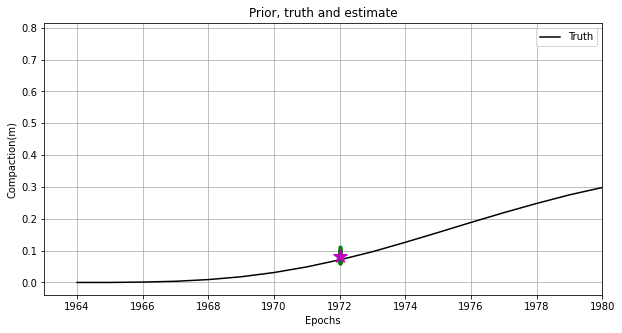

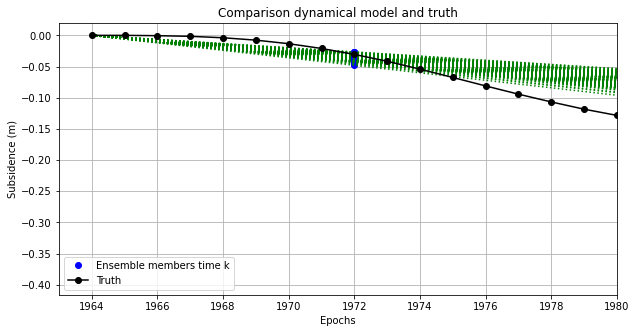

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot((1964+epoch)*np.ones(Ne), -x_p2, 'g.')
ax.plot(dates, -dh, 'k-', label='Truth')
ax.plot(1964+epoch, -deep_estimate2, 'm*', markersize =15)
ax.set_title('Prior, truth and estimate')
ax.set(xlabel='Epochs', ylabel='Compaction(m)')
ax.set_xlim([1963, 1980])
ax.legend()
ax.grid(True)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot((1964+epoch)*np.ones(Ne), -forecast_sub[:,epoch], 'bo', label='Ensemble members time k')
for i in range(Ne):
    ax.plot(dates, -forecast_sub[i,:], 'g:')

ax.plot(dates,disp_u,'ko-', label='Truth')

ax.set_title('Comparison dynamical model and truth')
ax.set(xlabel='Epochs', ylabel='Subsidence (m)')
ax.set_xlim([1963, 1980])
ax.legend()
ax.grid(True)

if nrun > 1:
    ## and histogram of maximal weight to get an idea of weight collapse
    fig = plt.figure(figsize=(10,5))
    n1, bins1, patches = plt.hist(w_maxOPF, 50, density=True, facecolor ='grey', alpha=1)
    plt.grid(True)
    plt.xlim(0, 0.1)
    #plt.ylim(0, 50)
    plt.xlabel('max $\mathrm{w_i}$')
    plt.ylabel('occurrences')
    plt.savefig('figures/histogramNy9_Ne100_OPPFcompaction.png')

## Particle filter with optimal proposal for 3 time steps


In [9]:
ep = np.array([1970, 1980, 1990])

In [10]:
tstep = 3

## Initialize
Id = np.identity(Ny)

# To save the results for each time step (and display after)
ens_comp = np.zeros((Ne, tstep))
ens_sub1 = np.zeros((Ny, Ne))
ens_sub2 = np.zeros((Ny, Ne))
ens_sub3 = np.zeros((Ny, Ne))

weight = np.zeros((Ne, tstep))
estimate_t = np.zeros(tstep)

# Prior
x_p2 = np.zeros(Ne)
x_p_OP = np.zeros((Ny, Ne))

w_maxOPF = np.zeros(nrun)

# observation model
H = Id
# Model error
eps = np.zeros((Ny, 1))

date0 = dates[0]
disp0 = np.zeros(Ny)

p_w = np.ones(Ne, dtype=np.float64)

for t in range(tstep):
    epoch = ep[t] - 1964
    
    # uz prior of deformation (state)
    ux_p_def = np.zeros((Ny, Ne))
    uy_p_def = np.zeros((Ny, Ne))
    uz_p_def = np.zeros((Ny, Ne))

    forecast_k = np.zeros((Ny, Ne)) 
    forecast_sub = np.zeros((Ne, nepoch))
    
    forecast_x0 = np.zeros((Ny, tstep))
    
    dlpsi = np.zeros((Ne, Ny), dtype=np.float64)
   
    
    # Data
    y0 = np.zeros((Ny, 1)) # time k-1
    y1 = np.zeros((Ny, 1)) # time k

    e = np.random.normal(np.zeros(Ny), sigma_e) # in m 
    y1 = df_synthdata.iloc[:, epoch+2] #+ e
    
    ## Create state vectors evolving in time: M(x_(k-1)) -> x_k
    # step at time t(k-1): x(k-1)~N(0,Id)
    #x0 =  np.random.multivariate_normal(np.zeros(Ny), Id)
    # Initial condition: we have a subsidence du0 for q period dt0
    x0 = disp0*np.ones(Ny) + forecast_x0[:,t]
     
    #################################################
    # Analytical expression of the optimal proposal #
    #################################################
    ## Create the dynamical model error
    q = (1e-3)**2 # variance (notation is a bit stupid but for step by step check)
    eps = np.random.normal(np.zeros(Ny), np.sqrt(q)) # mean and SD, model error
    # Create the model covariance fill with the values of eps in the diagonal
    Q_eps = np.zeros((Ny,Ny))
    np.fill_diagonal(Q_eps, q) # variance

    # step at time tk
    x1 = df_disp.iloc[:, epoch+2]
    # Create the state at time tk: M = a.Id with a = 0.5
    x1 = x1.to_numpy() + eps
    #x1 =  np.random.multivariate_normal(np.zeros(Ny), a*x0)

    ## Create the observations
    # Create the measurement  covariance fill with the values of e in the diagonal
    Q_e = np.zeros((Ny,Ny))
    np.fill_diagonal(Q_e, (sigma_e)**2) # variance in the diagonal-> in m2
        
    ## Compute the mean and covariance of the proposal such as ~N(mk,Q)
    Q_inv = np.linalg.inv(Q_eps) + multi_dot([H.T, np.linalg.inv(Q_e), H])
    Q = np.linalg.inv(Q_inv)

    mk = Q * ( np.linalg.inv(Q_eps)*x1 + multi_dot([H.T, np.linalg.inv(Q_e), y1]) )


    # write in a slightly different way because we want a Nx x 1 vector for mk
    mk = np.diag(mk)
    
    var_lik = np.diag(Q_eps + multi_dot([H.T, Q_e, H]))
    
    '''
    Now we can draw a prior for the deformation but we need a prior for the compaction coefficient of the reservoir and a prior for a state in the shallow subsurface
    ''' 
    ## Create the priors:
    # Prior of displacement with proposal density from Doucet et al. 2001
    cov_prior = np.diag(Q)
    mk_shall = np.zeros(len(mk))
    for i in range(Ny):
        x_p_OP[i,:] = np.random.normal(mk[i], np.sqrt(cov_prior[i]), Ne)
        
    ## Create the prior of compaction directly with the observation
    # Matrices for the initial p(x) ~ N(mx, sigmax) --> it will be a single value for a homogeneous reservoir
    m_x = np.random.normal(np.zeros(Nx), sigma_prior_deep)
    sigma_x = np.zeros((Nx,Nx))
    np.fill_diagonal(sigma_x, (sigma_prior_deep)**2) # variance
    
    # Compute mean and prior of the multivariate distribution
    # 1) we need the matrix A which maps compaction states to subsidence states
    # dimension (Ny x 1), for each observation point the expression of the jth component of A is:
    # SUM(u_i) with i the nuclei          
    # N.B.: we set the compaction dh=1
    u_deep_cart = np.zeros(Ny)   
    for i in range(len(nuclei_pos)):
        u_deep_cart = u_deep_cart + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[i,:], 1*n_nuclei, nu, dl2, grid_degree) 

    # we just want the vertical componant for now
    A = u_deep_cart[2]
    
    # 2) We apply the definition of th multivariate gaussian for the mean m_x and the standard deviation P_x
    # note that mu_x is a scalar in the case of a homogeneous reservoir (=1 state of compaction)
    #mat_inv = np.dot(A*sigma_x, A.T)# + Q_e
    mat_inv = np.dot(A*sigma_x, A.T) + sigma_e**2 #np.diag(Q_e) I tried with the square matrix but not sure because of the dimension
    mat_inv = 1/ mat_inv
    #print('mat_inv', mat_inv)
    part1 = (sigma_x * A) * mat_inv # just the different part in the expression
    part2 = (y1.to_numpy() - A*m_x)
    prod = np.dot(part1, part2)
    mu_x = m_x + prod 
    
    # Expression for the variance P_x
    part3 = sigma_x * A
    part4 = sigma_x * A * mat_inv
    prod = np.dot(part3, part4.T) ## To check: I think we should tranpose in the expression of P_x
    P_x = sigma_x - prod
    
    ## Now we can sample the prior ensemble of compaction states with our new optimal proposal!
    x_p2 = np.random.normal(mu_x, np.sqrt(P_x[0,0]), Ne) # in Pa -1, the python function needs a SD    
    
    ## Compute the prior ensemble of subsidence states from prior of compaction states
    for i in range(Ne): # take the ith set of prior compaction
        u_field =0
        for j in range(n_nuclei): # take the contribution of all nuclei at the Ny observation points
            u_field = u_field + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[j,:], x_p2[i]*n_nuclei, nu, dl2, grid_degree)
        
        # displacement at time tk-1 given the prior at time tk-2
        uz_p_def[:,i] = u_field[2] # only need this component for now
    
        # Compute rate for the dynamical model and get the displacement at the time k
        rate = (uz_p_def [:,i] - disp0) / (dates[epoch] - date0)
        
        # Ensemble members at time k: 
        #(rate of dimension Ny)
        # forecast_k of dimension (Ny x Ne)
        forecast_k[:,i] = disp0 + rate * (dates[epoch] - date0)
        
        # For the observation point #4 for the plot
        forecast_sub[i,:] = disp0[4] + rate[4] * (dates - date0)
    
    ## Run the particle filter
    ## Calculation of the difference data/model
    u_p_def = forecast_k.T

    # Difference data and model prediction at time k
    for i in range(Ne):
        for j in range(Ny):            
            dlpsi[i,j] = (df_synthdata.iloc[j, epoch+2] - u_p_def[i,j])**2 # in meter
    
    # Calculation of the likelihoods: gaussian distribution
    for i in range(Ne):
        dlpsi[i, :] = (1/sqrt(2*pi*var_lik))*np.exp(-0.5*dlpsi[i, :]/(var_lik))
    # Calculation of the weights
    for i in range(Ne):
        for j in range(Ny):
            p_w[i] = p_w[i] * dlpsi[i,j]

    # Normalization
    p_w = p_w / np.sum(p_w)
    
     ###############################
    # Analysis for the simulation #
    ###############################
    ## Weighted mean for the estimation of the compaction coefficient
    estimate2 = np.zeros(Nx)

    deep_estimate2 = np.sum(np.multiply(x_p2, p_w.T)) #estimate2[Nx-1]   
    
    estimate_t[t] = deep_estimate2
    weight[:,t] = p_w
    
    ens_comp[:, t] = x_p2
    
    if t == 0:
        ens_sub1 = forecast_sub[:, epoch]
    elif t == 1:
        ens_sub2 = forecast_sub[:, epoch]
    elif t == 2:
        ens_sub3 = forecast_sub[:, epoch]
        
    u_field =0
    for j in range(n_nuclei):
        u_field = u_field + nucleus_u_cartesian(obs[:,0], obs[:,1], obs[:,2], nuclei_pos[j,:], deep_estimate2, nu, vol_nucl, grid_degree)
    forecast_x0[:, t] = u_field[2]
    
    disp0 = u_field[2]
    date0 = dates[epoch]

    

## Analysis

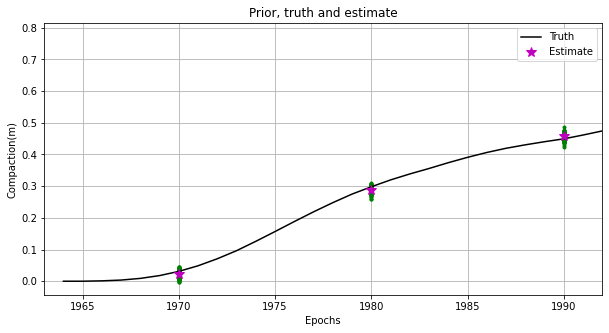

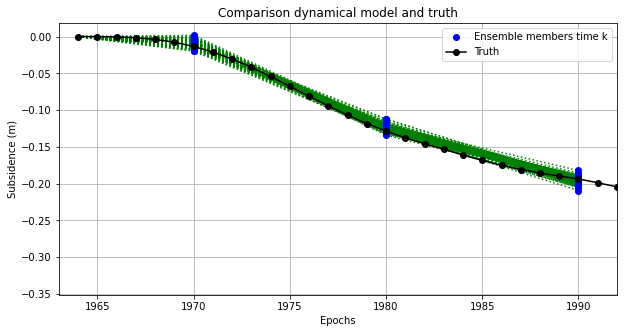

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot((ep[0])*np.ones(Ne), -ens_comp[:,0], 'g.')
ax.plot((ep[1])*np.ones(Ne), -ens_comp[:,1], 'g.')
ax.plot((ep[2])*np.ones(Ne), -ens_comp[:,2], 'g.')
ax.plot(dates, -dh, 'k-', label='Truth')

ax.plot(ep[0], -estimate_t[0], 'm*', markersize =10, label='Estimate')
ax.plot(ep[1], -estimate_t[1], 'm*', markersize =10)
ax.plot(ep[2], -estimate_t[2], 'm*', markersize =10)

ax.set_title('Prior, truth and estimate')
ax.set(xlabel='Epochs', ylabel='Compaction(m)')
ax.set_xlim([1963, 1992])
ax.legend()
ax.grid(True)


#######################################
fig, ax = plt.subplots(figsize=(10,5))
for i in range(Ne):
    ax.plot([1964, 1970, 1980, 1990], [0, -ens_sub1[i], -ens_sub2[i], -ens_sub3[i]], 'g:')
ax.plot(ep[0]*np.ones(Ne), -ens_sub1, 'bo', label='Ensemble members time k')
ax.plot(ep[1]*np.ones(Ne), -ens_sub2, 'bo')
ax.plot(ep[2]*np.ones(Ne), -ens_sub3, 'bo')
    
ax.plot(dates,disp_u,'ko-', label='Truth')

ax.set_title('Comparison dynamical model and truth')
ax.set(xlabel='Epochs', ylabel='Subsidence (m)')
ax.set_xlim([1963, 1992])
ax.legend()
ax.grid(True)